In [1]:
%matplotlib inline
# import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from collections import Counter 

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

### target discrete distribution

In [11]:
target_dist = dict()
for k in range(7):
    target_dist[k+1] = k+1

In [12]:
target_dist

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [13]:
def plot_discrete_pmf(dist):
    x = dist.keys()
    y = dist.values()
    plt.bar(x, y)

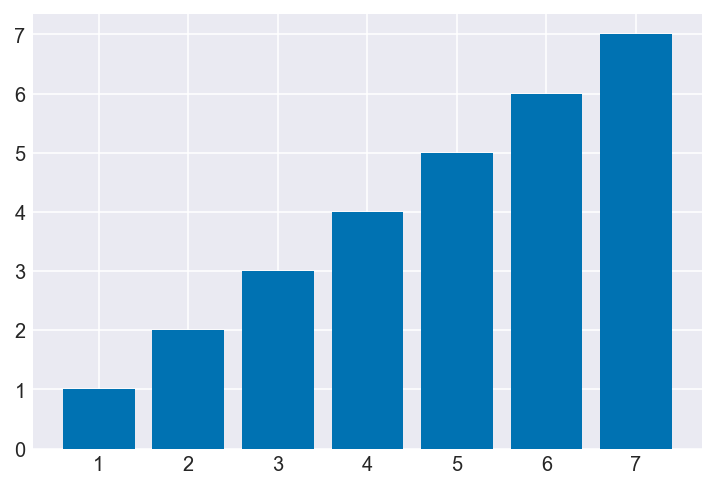

In [14]:
plot_discrete_pmf(target_dist)

In [18]:
stats.uniform.rvs()

0.4151590769602227

In [38]:
def next_param(param, target_dist):
    "random walk propose function to generate next param state"
    params = target_dist.keys()
    upperbound = max(params)
    lowerbound = min(params)
    
    # decide left or right
    p = stats.uniform.rvs()
    # propose current if at the bounded range
    if p > 0.5:
        proposed = min(param + 1, upperbound)
    else:
        proposed = max(param - 1, lowerbound)
        
    # decide if accept
    p_accept = min(1, target_dist[proposed] / target_dist[param])
    p = stats.uniform.rvs()
           
    return proposed if p < p_accept else param


In [40]:
test = [next_param(4, target_dist) for k in range(100)]

### run metropolis algorithm

In [44]:
theta = 4
num_steps = 100
hist = np.zeros(100)
hist[0] = theta
for idx in range(1, num_steps):
    current_param = hist[idx-1]
    hist[idx] = next_param(current_param, target_dist)
    

In [45]:
cnt = Counter(hist)

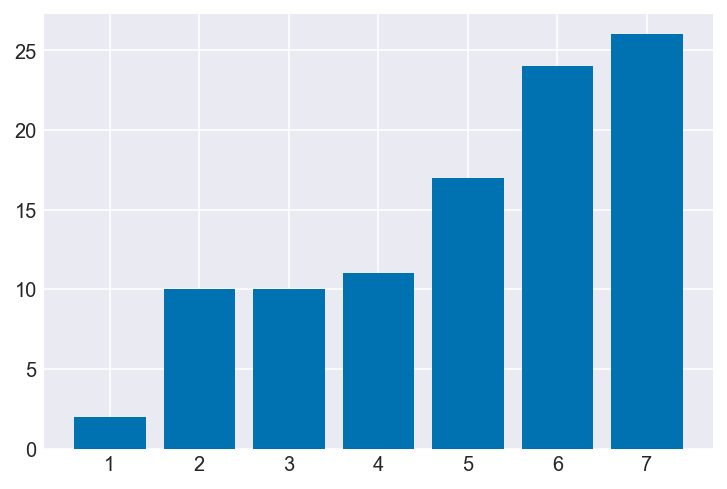

In [48]:
plot_discrete_pmf(dict(cnt))

In [56]:
def run_metropolis(theta, num_steps, target_dist):
    "random walk metropolis algorithm"
    
    hist = np.zeros(num_steps)
    hist[0] = theta
    for idx in range(1, num_steps):
        current_param = hist[idx-1]
        hist[idx] = next_param(current_param, target_dist)
    return hist

### alternative target dist

In [65]:
target_dist = dict(zip(range(1, 7), np.random.permutation(7) + 1))

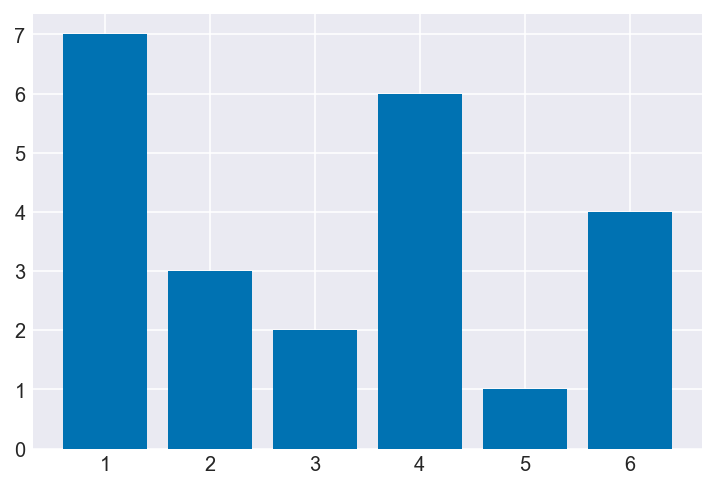

In [66]:
plot_discrete_pmf(target_dist)

In [67]:
hist = run_metropolis(4, 500, target_dist)

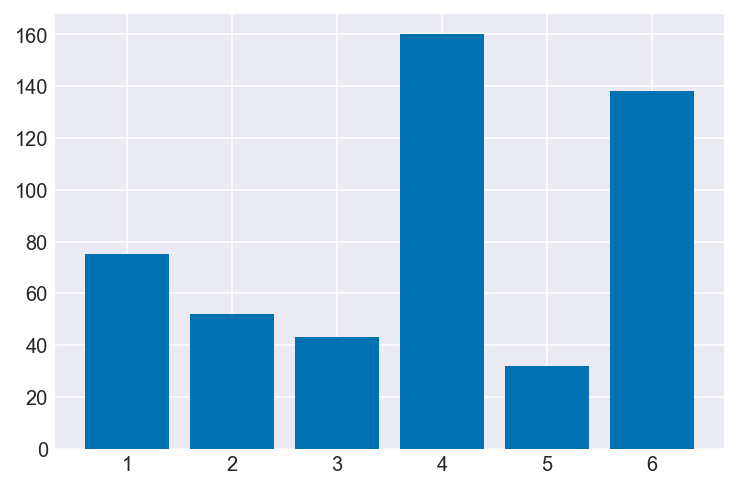

In [68]:
cnt = Counter(hist)
plot_discrete_pmf(dict(cnt))

### show trajectory

In [51]:
def plot_trajectory(hist):
    plt.plot(hist, range(len(hist)))

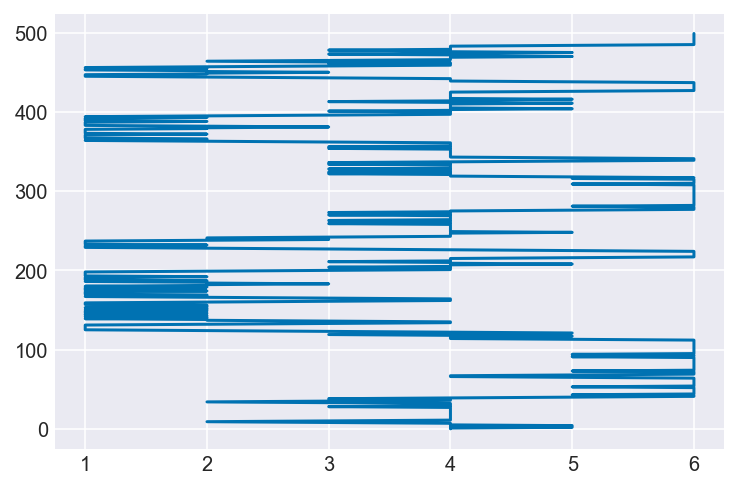

In [69]:
plot_trajectory(hist)

### TODO: animate the estimated distribution in time

### Find theoretical estimated target distribution

In [86]:
def create_random_pmf(num):
    return dict(zip(range(1, num+1), np.random.permutation(num) + 1))

In [87]:
def create_zero_pmf(num):
    return dict(zip(range(1, num+1), np.zeros(num+1)))

In [88]:
create_random_pmf(3)

{1: 3, 2: 2, 3: 1}

In [91]:
create_zero_pmf(7)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}

In [95]:
target_dist = dict()
for k in range(7):
    target_dist[k+1] = k+1

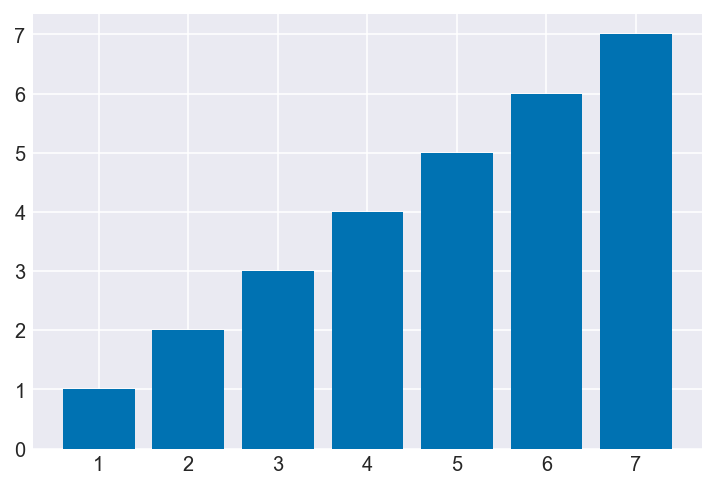

In [97]:
plot_discrete_pmf(target_dist)

In [166]:
prior_dist = create_zero_pmf(7)
theta = 4
num_steps = 3
prior_dist[theta] = 1

In [167]:
def propagate_distribution(prior_dist, target_dist):
    "one step forward estimated distribution"
    
    # loop each param
    params = target_dist.keys()
    num_params = len(params)
    dist = create_zero_pmf(num_params)
    for p in params:
        dist[p] = calculate_chain_prob(p, prior_dist, target_dist)
    
    return dist

In [215]:
def calculate_chain_prob(param, prior_dist, target_dist):
    "calculate the next stage pmf value for the specified param"
    
    # pmf(param) is the sum of prob jumping from left and right
    
    upperbound = max(target_dist.keys())
    lowerbound = min(target_dist.keys())
    
    left_param = param -1
    if left_param >= lowerbound:
        # prob if jumping from the left
        left_prob = 0.5 * min(1, target_dist[param] / target_dist[left_param])
        left_prior_prob = prior_dist[left_param]
    else:
        # at bounary, left is the same as current
        left_prob = 0.5
        left_prior_prob = 0
    
    right_param = param + 1
    if right_param <= upperbound:
        right_prob = 0.5 * min(1, target_dist[param] / target_dist[right_param])
        right_prior_prob = prior_dist[right_param]
    else:
        right_prob = 0.5
        right_prior_prob = 0
        
    #--------------------------------------------------------------------
    # stay prob: not going left nor right
    #--------------------------------------------------------------------    
    if left_param >= lowerbound:
        prob_to_left = min(1, target_dist[left_param] / target_dist[param])
    else:
        prob_to_left = 0
        
    if right_param <= upperbound:
        prob_to_right = min(1, target_dist[right_param] / target_dist[param])
    else:
        prob_to_right = 0
    
    stay_prob = 0.5 * (1-prob_to_left) + 0.5 * (1-prob_to_right)
    
    return left_prior_prob * left_prob + right_prior_prob * right_prob + prior_dist[param] * stay_prob


In [216]:
def metroplis_random_walk(step, prior_dist, target_dist):
    for k in range(step):
        prior_dist = propagate_distribution(prior_dist, target_dist)
    return prior_dist

In [229]:
result = metroplis_random_walk(3, prior_dist, target_dist)

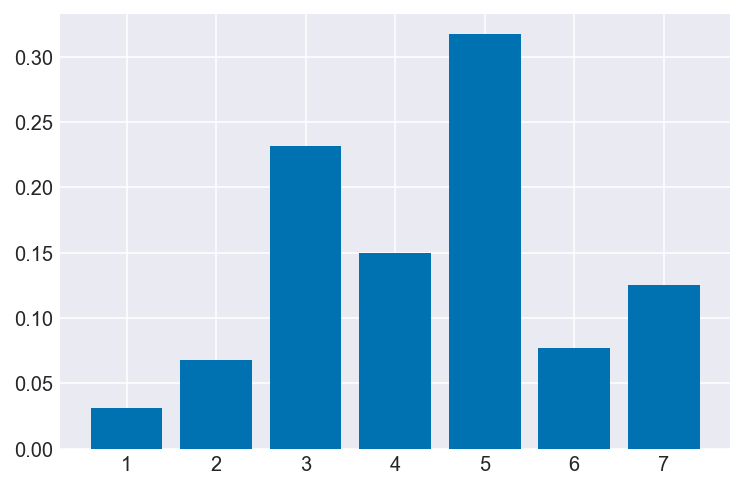

In [230]:
plot_discrete_pmf(result)

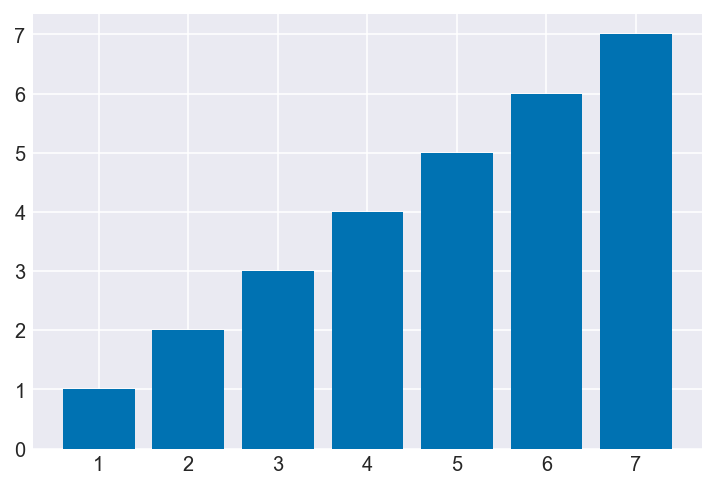

In [172]:
plot_discrete_pmf(target_dist)

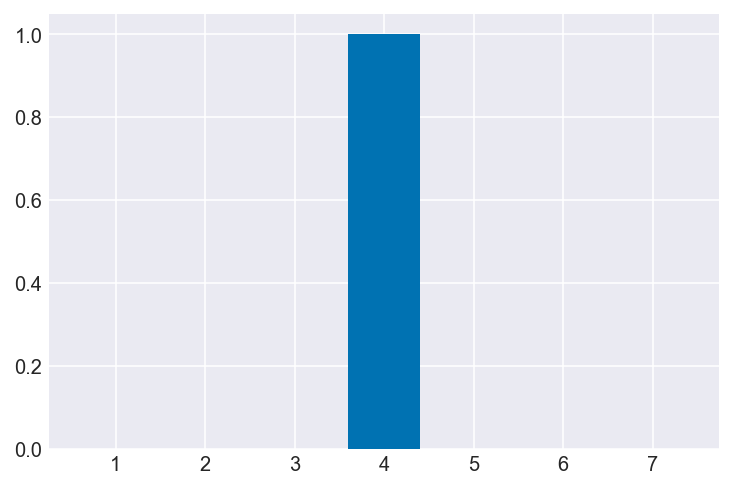

In [173]:
plot_discrete_pmf(prior_dist)